<a href="https://colab.research.google.com/github/maddswall/r-cuboulder-sentiment-analysis/blob/main/Copy_of_Bertopic_2020_CU_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##NLP Analysis on Reddit Comments From the r/cuboulder Community.




In [ ]:
#!pip install nltk
#!pip install spacy
#!pip install sklearn

In [ ]:
import pandas as pd

In [ ]:
!git clone https://github.com/maddswall/r-cuboulder-sentiment-analysis.git

fatal: destination path 'r-cuboulder-sentiment-analysis' already exists and is not an empty directory.


In [ ]:
df = pd.read_csv('/content/r-cuboulder-sentiment-analysis/cu_comments.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])

In [ ]:
#simple analytics
shape = df.shape

print(f'There are {shape[0]} rows and {shape[1]} columns')

There are 18302 rows and 4 columns


In [ ]:
#take a look at the first few rows
df.head()

,ID,title,date,comment
0,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Props on you for posting something original an...
1,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Haha I actually caught myself ducking a bit wh...
2,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,This is sooo good!
3,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Finally something that's not just bitching abo...
4,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,How tf did you not crash


In [ ]:
# A look at the posts with the highest comments.
top_post = df.groupby('title').size().reset_index(name='count').sort_values('count', ascending=False)
top_post.head(10)

,title,count
656,Vaccine Requirement for All CU System Students...,358
143,"CU to mandate masks indoors again, regardless ...",345
118,CU Boulder to begin spring semester remotely,288
603,The official CU Boulder Fall ‘20 COVID-19 plan...,179
62,Basically no spring break. Yay.,145
412,Make the vax mandatory at CU,114
214,FINALLY. Let's hope they enforce it.,112
154,Can we all just try?,111
208,Everyone in Darley North was just given three ...,109
192,Does anyone have any information on the CD’s t...,108


In [ ]:
#longest comment
df['comment_count'] = df.comment.str.len()
df.sort_values('comment_count', ascending =False).head(10)

,ID,title,date,comment,comment_count
2488,i48i2e,More Details in the Coming Weeks,2020-08-05 16:28:01,"Dear Faculty and Staff,\n\nGet ready! We’re go...",8865
5360,j9sm19,But it doesn’t matter unless you VOTE!,2020-10-12 15:10:14,It is so critical for everyone to vote. If you...,8623
16949,kcrqfj,When your prof didn't curve up.,2020-12-14 05:46:57,Another prof here. Gonna offer some counterpoi...,6568
8954,mv0k1z,CU and the Value of a Human Life,2021-04-20 21:12:49,Here is something i pick on a comment of a y...,6241
9815,k5rzi9,This is not great,2020-12-03 06:25:37,> Do you do the same?\n\nYes.\n\n> there are ...,5502
8396,iobr6b,Cc: Spectrum LLC,2020-09-07 17:24:09,I'm a resident of Spectrum and witnessed all t...,5329
2490,i48i2e,More Details in the Coming Weeks,2020-08-05 16:28:01,Activities\nWe are extending the moratorium on...,4657
7211,gr4eso,"Phil and Phriends are Phucking us over, change...",2020-05-26 19:59:52,Some things to consider...\n\nWould you person...,4649
16256,uq8wj2,Should we be raising standards in class?,2022-05-15 15:50:30,I’m a psych/neuroscience student who started f...,4600
7976,ie4hj5,Moved in Monday. Mom texted this morning to se...,2020-08-21 20:21:05,Hey man I just want to start by asking you to ...,4471


In [ ]:
#shortest values
short_comments = df.loc[df.comment_count < 5]
print(f'There are {len(short_comments)} comments less than 5 characters in length')
print('\nComment_count short frequency')
short_comments.comment_count.value_counts()

There are 303 comments less than 5 characters in length

Comment_count short frequency


4    105
3     86
1     67
2     45
Name: comment_count, dtype: int64

In [ ]:
short_comments.head(5)

,ID,title,date,comment,comment_count
12,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,🖤💛,2
309,etmm85,Ride on the Tragic Buff Bus,2020-01-25 05:17:41,BBB,3
446,mzc1k3,so grad appreciation days went well,2021-04-27 00:18:31,12,2
492,n0oj61,Vaccine Requirement for All CU System Students...,2021-04-28 20:52:46,1984,4
502,n0oj61,Vaccine Requirement for All CU System Students...,2021-04-28 20:52:46,Sko,3


In [ ]:
#removing posts that were removed or deleted by the user of the moderator
df = df[~((df['comment']=='[removed]') | (df['comment']=='[deleted]'))]

In [ ]:
df.shape

(17208, 5)

##Cleaning the Data and Removing Stop Words

In [ ]:
#removing punctuation from the comments column
import string
import re

#drop rows that contain [removed] or [deleted]
df.drop(df.loc[(df.comment == '[removed]') | (df.comment == '[deleted]')]\
        .index, inplace=True)

#drop comments less than 5 characters in length
df = df[df['comment_count'] >= 5]

#define a string of all punctuation characters
punct = string.punctuation
#define a regex to look for hyperlinks
url_regex = re.compile(r'http\S+|www.\S+')
#list of profanity to remove
cuss_words = ['fuck', 'shit', 'asshole', 'bitch', 'cunt', 'dick',\
              'pussy', 'transgenders', 'transgender', 'fucking']
filler_words = ['engineering']

def remove_punctuation(text):
  no_punct = text.lower()
  no_punct = "".join([char for char in no_punct if char not in punct])
  no_punct = url_regex.sub('', no_punct)
  no_special = re.sub(r'[^a-zA-Z0-9\s]', '', no_punct)
  no_special = no_special.strip()


  return no_special

df['cleaned_comment'] = df['comment'].apply(remove_punctuation)

In [ ]:
#removing stop words
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
  tokens = word_tokenize(text)
  filtered_tokens = [word for word in tokens if word.lower() not in stop_words
                     and word.isalpha() and word not in cuss_words and\
                     word not in filler_words]
  return " ".join(filtered_tokens)

df['cleaned_comment'] = df['cleaned_comment'].apply(remove_stopwords)
df['cleaned_comment'] = df['cleaned_comment'].str.replace('gon na', 'gonna')
df = df[df['cleaned_comment'] != '']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Lemmitization

In [ ]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Download the necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Create an instance of the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a single word based on its part of speech
def lemmatize_word(word, pos):
    """
    Lemmatize a word based on its part of speech.
    """
    # Map NLTK part of speech tags to WordNet part of speech tags
    if pos.startswith('J'):
        # Adjective
        pos_wordnet = wordnet.ADJ
    elif pos.startswith('V'):
        # Verb
        pos_wordnet = wordnet.VERB
    elif pos.startswith('N'):
        # Noun
        pos_wordnet = wordnet.NOUN
    elif pos.startswith('R'):
        # Adverb
        pos_wordnet = wordnet.ADV
    else:
        # Default to noun
        pos_wordnet = wordnet.NOUN

    # Lemmatize the word using the WordNetLemmatizer
    lemma = lemmatizer.lemmatize(word, pos=pos_wordnet)

    return lemma

# Define a function to lemmatize a sentence
def lemmatize_sentence(sentence):
    """
    Lemmatize a sentence.
    """
    # Tokenize the sentence into words
    words = nltk.word_tokenize(sentence)

    # Get the part of speech for each word
    pos_tags = nltk.pos_tag(words)

    # Lemmatize each word based on its part of speech
    lemmas = [lemmatize_word(word, pos) for word, pos in pos_tags]

    # Join the lemmatized words back into a sentence
    lemmatized_sentence = ' '.join(lemmas)

    return lemmatized_sentence

# Apply the lemmatize_sentence function to the cleaned_comment column
df['cleaned_comment'] = df['cleaned_comment'].apply(lemmatize_sentence)
df.reset_index(inplace=True, drop=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
df.head()

,ID,title,date,comment,comment_count,cleaned_comment
0,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Props on you for posting something original an...,73,prop post something original well edit sub
1,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Haha I actually caught myself ducking a bit wh...,95,haha actually catch duck bit go tunneled walkw...
2,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,This is sooo good!,18,sooo good
3,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Finally something that's not just bitching abo...,62,finally something thats bitch semester
4,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,How tf did you not crash,24,tf crash


Review cleaned text

In [ ]:
df['comment']

0        Props on you for posting something original an...
1        Haha I actually caught myself ducking a bit wh...
2                                       This is sooo good!
3        Finally something that's not just bitching abo...
4                                 How tf did you not crash
                               ...                        
16553    I'd like to see them dump the parking and buil...
16554    That’s just the thing - they don’t *want* peop...
16555    lol at getting downvoted, we all know who you ...
16556    Before I left employment 2 weeks ago with the ...
16557    A few years ago I had to go band-aid a leak in...
Name: comment, Length: 16558, dtype: object

In [ ]:
df['cleaned_comment']

0               prop post something original well edit sub
1        haha actually catch duck bit go tunneled walkw...
2                                                sooo good
3                   finally something thats bitch semester
4                                                 tf crash
                               ...                        
16553    id like see dump park build even housing maybe...
16554    thats thing dont want people commute goal redu...
16555    lol get downvoted know come defend show let kn...
16556    left employment week ago university sit assist...
16557    year ago go bandaid leak ceiling ketchum regen...
Name: cleaned_comment, Length: 16558, dtype: object

In [ ]:
df.shape

(16558, 6)

## Install packages

In [ ]:
%%capture
!pip install bertopic

## Use BerTopic model to do topic extraction!

I found it very handful and easy to use.
Here is the GIthub page. They also have a detailed documentation.
https://github.com/MaartenGr/BERTopic


In [ ]:
from bertopic import BERTopic
from umap import UMAP

# Make sure the results can be reproduced
umap_model = UMAP(n_neighbors=15, n_components=5,
                  min_dist=0.0, metric='cosine', random_state=43)

from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english")

topic_model = BERTopic(language="english",embedding_model = 'all-mpnet-base-v2',
                       vectorizer_model=vectorizer_model, n_gram_range=(1,3),
                       umap_model=umap_model,
                       calculate_probabilities=True, verbose=True)

topics, probs = topic_model.fit_transform(df['cleaned_comment'])

Batches:   0%|          | 0/518 [00:00<?, ?it/s]

2023-05-03 21:36:19,744 - BERTopic - Transformed documents to Embeddings
2023-05-03 21:36:58,269 - BERTopic - Reduced dimensionality
2023-05-03 21:37:40,755 - BERTopic - Clustered reduced embeddings


In [ ]:
topic_model.reduce_topics(list(df['cleaned_comment']), nr_topics=100)

2023-05-03 21:37:45,101 - BERTopic - Reduced number of topics from 221 to 100


In [ ]:
#top post sorted by number in each topic
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,6960,-1_student_cu_class_im
1,0,1113,0_vaccine_covid_virus_spread
2,1,611,1_class_professor_grade_semester
3,2,571,2_vote_trump_government_regent
4,3,344,3_housing_rent_boulder_city
5,4,306,4_bus_buff_bike_car
6,5,291,5_email_link_post_comment
7,6,267,6_thank_thanks_appreciate_nice
8,7,260,7_blame_student_reddit_suck
9,8,232,8_suicide_feel_empathy_mental


In [ ]:
#making a topic data frame
topic_df = topic_model.get_document_info(list(df['cleaned_comment']))
topic_df

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,prop post something original well edit sub,5,5_email_link_post_comment,email - link - post - comment - send - delete ...,1.000000,False
1,haha actually catch duck bit go tunneled walkw...,3,3_housing_rent_boulder_city,housing - rent - boulder - city - building - l...,1.000000,False
2,sooo good,6,6_thank_thanks_appreciate_nice,thank - thanks - appreciate - nice - awesome -...,0.099985,False
3,finally something thats bitch semester,-1,-1_student_cu_class_im,student - cu - class - im - like - make - camp...,0.196593,False
4,tf crash,-1,-1_student_cu_class_im,student - cu - class - im - like - make - camp...,0.468218,False
...,...,...,...,...,...,...
16553,id like see dump park build even housing maybe...,-1,-1_student_cu_class_im,student - cu - class - im - like - make - camp...,0.556758,False
16554,thats thing dont want people commute goal redu...,-1,-1_student_cu_class_im,student - cu - class - im - like - make - camp...,0.698188,False
16555,lol get downvoted know come defend show let kn...,-1,-1_student_cu_class_im,student - cu - class - im - like - make - camp...,0.255412,False
16556,left employment week ago university sit assist...,-1,-1_student_cu_class_im,student - cu - class - im - like - make - camp...,0.001697,False


Look at the top words of one of the topic.

In [ ]:
topic_model.get_topic(0)

[('vaccine', 0.028900668270383744),
 ('covid', 0.021344751418632256),
 ('virus', 0.017589214667902735),
 ('spread', 0.013071838073184735),
 ('people', 0.012882909795532417),
 ('vaccinate', 0.012056392654557452),
 ('variant', 0.01055308703094801),
 ('immunity', 0.010339893353555122),
 ('death', 0.01001530865328176),
 ('die', 0.010010678895339712)]

In [ ]:
# Find topics related to word "covid"
similar_topics, similarity = topic_model.find_topics("covid", top_n=5); similar_topics

[0, 98, 71, 42, 10]

In [ ]:
# look at words in topic 10, which is related to word "covid"
topic_model.get_topic(10)

[('mask', 0.12467242882737158),
 ('wear', 0.08054496409691986),
 ('mandate', 0.026590502651153283),
 ('outside', 0.014541538221721037),
 ('people', 0.01382423576979361),
 ('require', 0.012136951350104659),
 ('masks', 0.01170100586962712),
 ('goal', 0.01054601852034268),
 ('vaccinate', 0.010392536676748058),
 ('protect', 0.009691691159454481)]

In [ ]:
#appending the topics to the original data frame for a deep dive into topics
df['topic'] = topics

## Visualizations

In [ ]:
topic_model.visualize_topics()

## Add Sentiment Analysis scores to df

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

sid = SentimentIntensityAnalyzer()

In [ ]:
#use inbuilt sid.polarity_scores to extract scores. Read on for the results
df['scores'] = df['cleaned_comment'].apply(lambda review: sid.polarity_scores(review))

#We break the dict generated above and pull only column 'compound'
df['compound']  = df['scores'].apply(lambda s : s['compound'])

#the step above returns values from -1 to 1.
df['comp_score'] = df['compound'].apply(lambda n : 'pos' if n >=0 else 'neg')


df.drop(df[df.compound == 0.0000].index, inplace=True)

df.head(5)

,ID,title,date,comment,comment_count,cleaned_comment,topic,scores,compound,comp_score
0,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Props on you for posting something original an...,73,prop post something original well edit sub,9,"{'neg': 0.0, 'neu': 0.532, 'pos': 0.468, 'comp...",0.5267,pos
1,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Haha I actually caught myself ducking a bit wh...,95,haha actually catch duck bit go tunneled walkw...,25,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.4588,pos
2,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,This is sooo good!,18,sooo good,114,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,pos
3,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Finally something that's not just bitching abo...,62,finally something thats bitch semester,-1,"{'neg': 0.487, 'neu': 0.513, 'pos': 0.0, 'comp...",-0.5859,neg
4,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,How tf did you not crash,24,tf crash,-1,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou...",-0.4019,neg


In [ ]:
# pos vs negative comments
comp_dist = df.groupby('comp_score').size().reset_index(name = 'count').sort_values('count',ascending = False)

comp_dist.head()

,comp_score,count
1,pos,7966
0,neg,4581


## Combine sentiment df and topic extraction information into one

In [ ]:
combined_df = pd.concat([df, topic_df], axis=1)

In [ ]:
combined_df.head()

,ID,title,date,comment,comment_count,cleaned_comment,topic,scores,compound,comp_score,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Props on you for posting something original an...,73.0,prop post something original well edit sub,9.0,"{'neg': 0.0, 'neu': 0.532, 'pos': 0.468, 'comp...",0.5267,pos,prop post something original well edit sub,5,5_email_link_post_comment,email - link - post - comment - send - delete ...,1.000000,False
1,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Haha I actually caught myself ducking a bit wh...,95.0,haha actually catch duck bit go tunneled walkw...,25.0,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.4588,pos,haha actually catch duck bit go tunneled walkw...,3,3_housing_rent_boulder_city,housing - rent - boulder - city - building - l...,1.000000,False
2,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,This is sooo good!,18.0,sooo good,114.0,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,pos,sooo good,6,6_thank_thanks_appreciate_nice,thank - thanks - appreciate - nice - awesome -...,0.099985,False
3,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,Finally something that's not just bitching abo...,62.0,finally something thats bitch semester,-1.0,"{'neg': 0.487, 'neu': 0.513, 'pos': 0.0, 'comp...",-0.5859,neg,finally something thats bitch semester,-1,-1_student_cu_class_im,student - cu - class - im - like - make - camp...,0.196593,False
4,iate23,Drone shots of our desolate campus during the ...,2020-08-16 14:36:45,How tf did you not crash,24.0,tf crash,-1.0,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou...",-0.4019,neg,tf crash,-1,-1_student_cu_class_im,student - cu - class - im - like - make - camp...,0.468218,False


In [ ]:
combined_df.to_csv('combined_df_2020.csv', index=False)

# Deep Dive into Topics

In [ ]:
# Find topics related to word "covid"
similar_topics, similarity = topic_model.find_topics("covid", top_n=5); similar_topics

[0, 98, 71, 42, 10]

In [ ]:
# creating a dataframe for the covid topics
covid = df.loc[(df.topic == 0)]

In [ ]:
# look at words in topic 0, which is related to word "covid"
topic_model.get_topic(0)

[('vaccine', 0.028900668270383744),
 ('covid', 0.021344751418632256),
 ('virus', 0.017589214667902735),
 ('spread', 0.013071838073184735),
 ('people', 0.012882909795532417),
 ('vaccinate', 0.012056392654557452),
 ('variant', 0.01055308703094801),
 ('immunity', 0.010339893353555122),
 ('death', 0.01001530865328176),
 ('die', 0.010010678895339712)]

#### Word cloud for covid

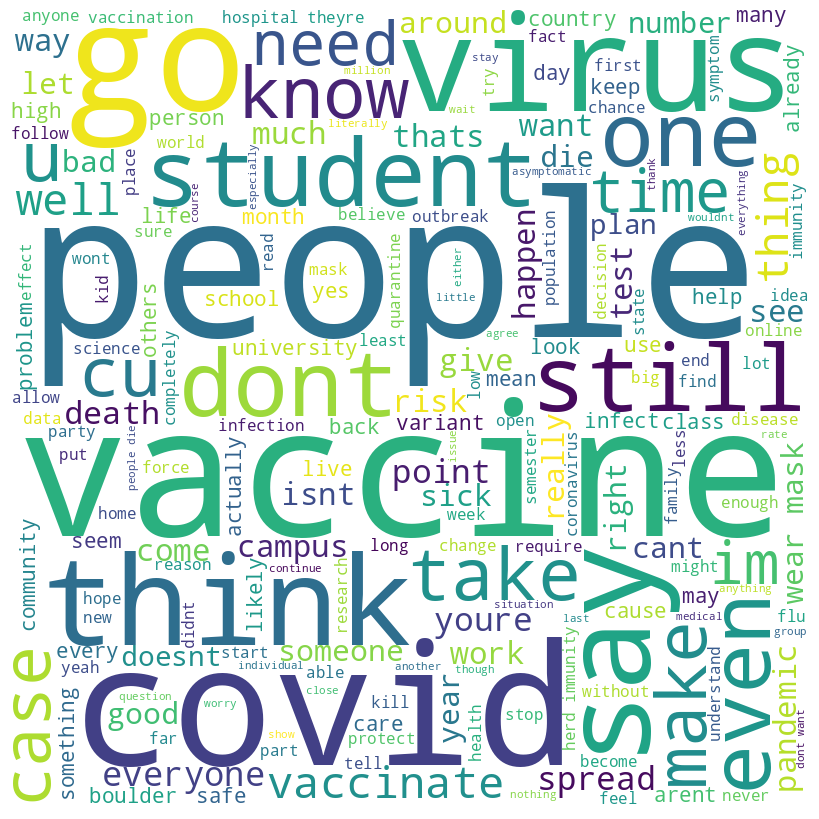

In [ ]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assume 'model' is the Bertopic model
topic_list = []
for comment in covid['cleaned_comment']:
  for x in comment.split():
    topic_list.append(x)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_text(' '.join(topic_list))

# plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:
#looping through and printing out all the comments for further analysis
covid_pos = covid.loc[covid.comp_score == 'pos'].sort_values('compound', ascending = False)

for i, x in enumerate(covid_pos['comment']):
  print('comment ' + str(i))
  print(x)
  print('-' * 40)

comment 0
Dear Faculty and Staff,

Get ready! We’re going to give you lots of information. This message is long but worth reading.

If you haven’t already, please look at the chancellor’s message from Friday. As a campus community, we all have been working hard to execute our plan for a safe and healthy return to campus on Aug. 24. We’re grateful to all of our faculty and staff for their hard work and focus on preparing the campus for fall 2020. We appreciate those of you who have been on campus and we’re excited to welcome back those who are returning at this time. 

We want to share details on our plan, including dates; which on-campus services will be available; which will remain remote; as well as more information on teaching, learning and the different modes of operation in which we’ll be engaging this fall. Our plan is comprehensive. We’ve included a significant level of detail for your reference and encourage you to revisit this message and to bookmark and regularly visit our CO

In [ ]:
# looping through to print out the negative comments
covid_neg = covid.loc[covid.comp_score == 'neg'].sort_values('compound', ascending = False)

for i, x in enumerate(covid_neg['comment']):
  print('comment ' + str(i))
  print(x)
  print('-' * 40)

comment 0
I want to see the poll results on what Americans would think if they were to find out that somebody's government purposely released a genetically modified highly virulent but comparatively benign variant (omicron) of (allegedly) somebody else's original man-made virus (SARS-COV-2) right at the moment it became apparent they had vaccinated as many people as they could and as soon as possible after the virus had naturally mutated to a strain more virulent and just as deadly as the original variant (delta). Seems a bit convenient that the vaccines aren't very effective at preventing omicron (however most people will barely or never even know they had it) but naturally acquired immunity from omicron effectively prevents delta.

Of course, it could just be total coincidence that a virus extremely similar to the one proposed for development in publicly available documents, complete with the unusual cleavage site and all, first appeared in the very city where that research was propo

### Topic 8 - Mental Health

In [ ]:
# Find topics related to word "covid"
similar_topics, similarity = topic_model.find_topics("mental health", top_n=5); similar_topics

[8, 91, 42, 56, 68]

In [ ]:
#creating data frame for mental health
mental_health = df.loc[(df.topic == 8)]

In [ ]:
#showing the top words for topic 8
topic_model.get_topic(8)

[('suicide', 0.028183836478053732),
 ('feel', 0.022384722051009786),
 ('empathy', 0.02157307179049117),
 ('mental', 0.01964547211559388),
 ('day', 0.01621260263877525),
 ('depression', 0.014936520528677279),
 ('alert', 0.014729631459238324),
 ('life', 0.013727536584647034),
 ('health', 0.013469926130632791),
 ('selfish', 0.013434756612142251)]

#### Word cloud for mental health

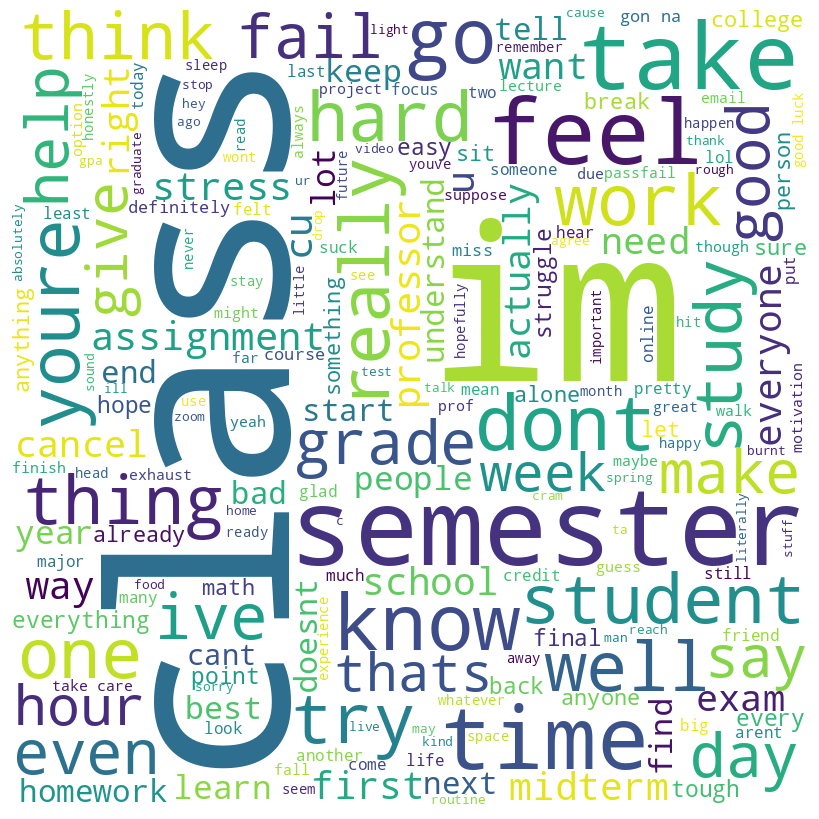

In [ ]:
# Find topics related to word "covid"
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assume 'model' is the Bertopic model
topic_list = []
for comment in mental_health['cleaned_comment']:
  for x in comment.split():
    topic_list.append(x)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate_from_text(' '.join(topic_list))

# plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:
#printing out the positive comments
mental_health_pos = mental_health.loc[mental_health.comp_score == 'pos'].sort_values('compound', ascending = False)

for i, x in enumerate(mental_health_pos['comment']):
  print('comment ' + str(i))
  print(x)
  print('-' * 40)

comment 0
You're not alone - it is tough to be holed up like this! There are a few things that can help. I think I read some of these posted by a guy who worked on a submarine?! I know I use them, and I do some others because I study online quite a bit because I live in Australia and study through American schools. So I've been doing online school for about a year when corona hit.

* Create a daily routine a stick with it.
* Include >30 min exercise everday. 
   * Focus on attendance, not performance. Avoid injury as it'll hurt your attendance.
   * I do crossfit 5x a week starting at 5pm. Sometimes I'm pretty sore, so those days are light/low intensity (a walk is fine!).
* Make reasonable excuses to get away from your computer / phone. 
   * I cook and sit down to eat breakfast, lunch and dinner. I like to take a walk to a nearby park, which takes 30 min round trip. I like to take my dog with me.
* Treat yourself to good food. 
   * Not junk food, but not horribly untasty healthy food

In [ ]:
#printing out the negative comments
mental_health_neg = mental_health.loc[mental_health.comp_score == 'neg'].sort_values('compound', ascending = False)

for i, x in enumerate(mental_health_neg['comment']):
  print('comment ' + str(i))
  print(x)
  print('-' * 40)

comment 0
You aren’t alone. I’m also taking a semester off and felt like a total loser and quitter for taking time to heal my body and mind.
----------------------------------------
comment 1
My first semester here my calc prof told us that a number of math professors at CU failed their first college math classes. I think a lot of them just had to relearn how to learn math, but obviously they got better at it. That story always helps me deal when coursework gets hard. It’s hard for everyone
----------------------------------------
comment 2
If you have no in person classes IDK... maybe go home.
----------------------------------------
comment 3
Just be glad you missed the annoying transition from D2L to Canvas that seemed to take my entire time in undergrad.
----------------------------------------
comment 4
yes! i’ve been swamped with papers every single week of the semester so far and i’m so beyond exhausted. i have two more due (one tomorrow, another monday) and i am putting them bo